In [ ]:
pip install statsmodels==0.11.0 -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

## Предобработка

Считаем данные и преобразуем их:
 - Так как работать будем с данными как с временным рядом, необходимо провести транспонирование. 
 - Столбец *Месяц* переведём в подходящий формат дат, остальные в числовой формат.
 - Эксперементально было выяснено, что в данных присутсвует не только автокорреляция столбца *Экспорт*, но и зависимость между ним и другими столбцами. Но для этого необходимо остальные столбцы сдвинуть, чтобы искать зависимость будущих данных только из настоящего времени.
 - Далее избавимся от появившихся после сдвига пустых значений.

In [ ]:
df = pd.read_excel('data/4.2 лесные перевозки.xlsx', index_col='Месяц').transpose()
df.index = pd.to_datetime(df.index, format="%Y/%m")
df = df.drop(['Вид перевозки'], axis=1)

df['Внутр. перевозки'] = df['Внутр. перевозки'].shift(1)
df['Импорт'] = df['Импорт'].shift(1)
df['Транзит'] = df['Транзит'].shift(1)

df = df.iloc[1:]
df = df.astype(int)
df = df.asfreq('MS')

df.head(3)

Месяц,Внутр. перевозки,Экспорт,Импорт,Транзит
2008-02-01,2708771,2835262,44149,27338
2008-03-01,2920482,3269750,50817,21573
2008-04-01,3071793,2866872,61096,30951


## Визуальная оценка ряда

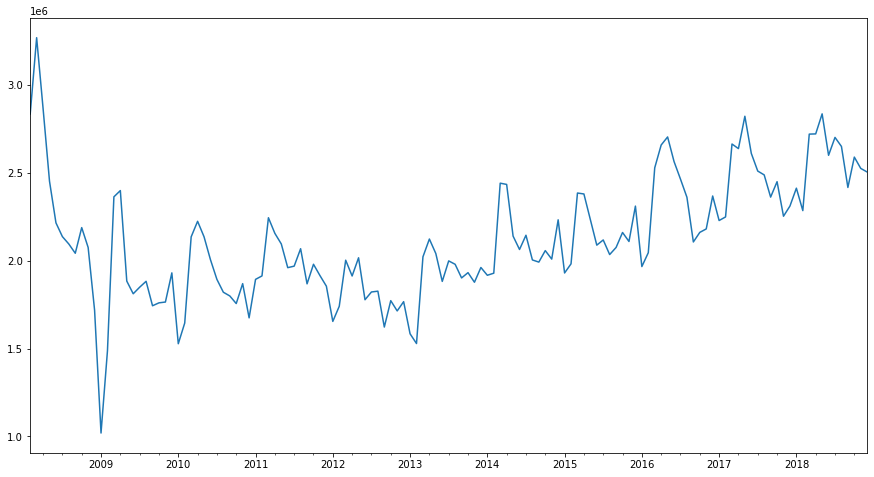

In [ ]:
plt.figure(figsize=[15, 8])
df.Экспорт.plot()
plt.show()

На графике видно, что данные в левом краю не соотвествуют общему тренду данных далее. И так как эти данные самые далекие от настоящего времени просто избавимся от них.

In [ ]:
df = df.loc['2009':]

## Разделение данных

Разделим данные на тестовую и тренировочную выборки

In [ ]:
train_size = int(df.shape[0] * 0.8)
df_train = df.iloc[:train_size]
df_test  = df.iloc[train_size:]
print(f'В тренировочной выборке находится {train_size} элементов')

В тренировочной выборке находится 96 элементов


## Построение модели

После проведения ряда экспериментов было выясненно, что наиболее точной моделью является модель, учитывающая данные из других столбцов. При подборе параметров __p, q, P,__ и __Q__ была составлена таблица зависимости критерия Акаике от параметров модели SARIMAX:

|   | Model                          | AIC     |
|---|--------------------------------|---------|
| 1 | SARIMAX(0, 1, 0)x(0, 1, 1, 12) | 2187.67 |
| 2 | SARIMAX(0, 1, 0)x(1, 1, 1, 12) | 2189.64 |
| 3 | SARIMAX(0, 1, 3)x(0, 1, 1, 12) | 2191.83 |
| 4 | SARIMAX(0, 1, 1)x(0, 1, 1, 12) | 2192.38 |
| 5 | SARIMAX(0, 1, 3)x(1, 1, 1, 12) | 2193.82 |

Несмотря на самый высокий показатель критерия Акаике у модели __SARIMAX(0, 1, 3)x(0, 1, 1, 12)__, выбор был между моделями __SARIMAX(0, 1, 3)x(0, 1, 1, 12)__ и __SARIMAX(0, 1, 3)x(1, 1, 1, 12)__, так как они учитывают авторегрессионную составляющую ряда. В конечном итоге была выбрана _

In [ ]:
exog = df_train.loc[:, df_train.columns != 'Экспорт']

model = sm.tsa.arima.ARIMA(df_train.Экспорт, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), exog=exog).fit()

## Оценка модели

Посмотрим, как представленная модель описывает тренировочные данные.

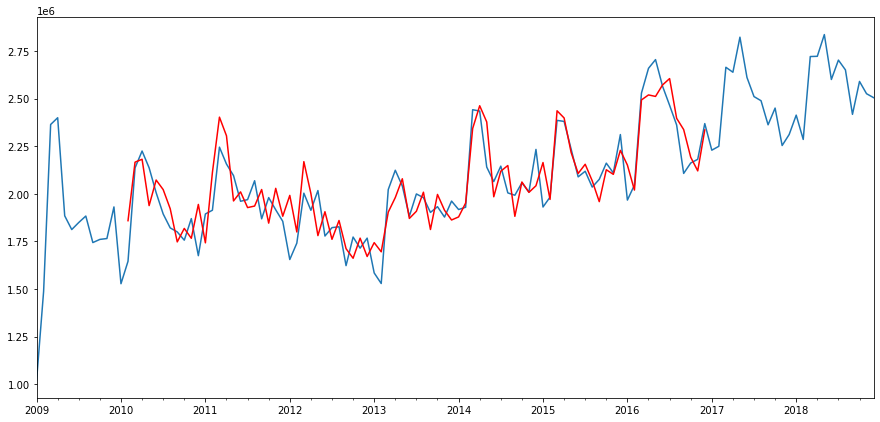

In [ ]:
plt.figure(figsize=(15,7))
df.Экспорт.plot()
model.fittedvalues[13:].plot(color='r')
plt.show()

А теперь проведём оценку на тестовой выборке

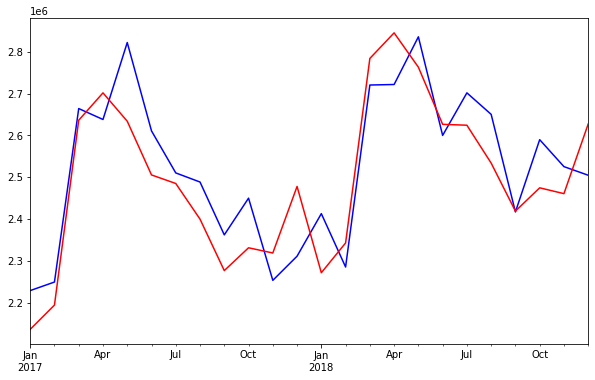

MSE: 9410829962 тонн
MAE: 86165 тонн
R2:  0.7020


In [ ]:
y_pred = model.predict(start=df_test.index.min(), end=df_test.index.max(), 
                            exog=df_test.loc[:, df_test.columns != 'Экспорт']) 

plt.figure(figsize=[10, 6])
df_test.Экспорт.plot(c='b')
y_pred.plot(c='r')
plt.show()

print(f'MSE: {mean_squared_error(df_test.Экспорт, y_pred):.0f} тонн')
print(f'MAE: {mean_absolute_error(df_test.Экспорт, y_pred):.0f} тонн')
print(f'R2:  {r2_score(df_test.Экспорт, y_pred):.4f}')

В конечном итоге имеем модель, предсказывающую данные с средней абсолютной ошибкой в 86165 тонн.